In [ ]:
import requests
import json
import pandas as pd
import time
from datetime import datetime

def to_unix_time(dt):
    return int(time.mktime(dt.timetuple()))

def extract_current(lat, lon, key):
    getUrl = 'https://api.openweathermap.org/data/2.5/air_pollution'
    response = requests.get(getUrl, params={"lat": lat, "lon": lon, "appid": key})
    return json.loads(response.content.decode('utf-8'))

# def extract_forecast(lat, lon, key):
#     getUrl = 'https://api.openweathermap.org/data/2.5/air_pollution/forecast'
#     response = requests.get(getUrl, params={"lat": lat, "lon": lon, "appid": key})
#     return json.loads(response.content.decode('utf-8'))

def extract_history(lat, lon, start, end, key):
    getUrl = 'https://api.openweathermap.org/data/2.5/air_pollution/history'
    response = requests.get(getUrl, params={"lat": lat, "lon": lon, "start": start, "end": end, "appid": key})
    return json.loads(response.content.decode('utf-8'))

# Transform
def transform_response(response):
    # Assuming the response has data in a list of dictionaries format
    df = pd.DataFrame(response['list'])
    df['dt'] = pd.to_datetime(df['dt'], unit='s')
    # Additional transformation steps can be added here as needed
    # Extract the 'aqi' value from the 'main' dictionary
    df['aqi'] = df['main'].apply(lambda x: x['aqi'])
    # Normalize the 'components' column to create separate columns for each component
    components_df = pd.json_normalize(df['components'])
    # Concatenate the new columns to the original dataframe
    df = pd.concat([df, components_df], axis=1)
    # Drop the 'main' and 'components' columns as they are no longer needed
    df.drop(columns=['main', 'components'], inplace=True)
    return df

# The App in action: Run custom functions if valid inputs are entered

# Sample latitude and longitude for demonstration
# Start time: January 1, 2021
start_dt = datetime(2021, 1, 1)
start = to_unix_time(start_dt)

# End time: December 31, 2022, 23:59:59
end_dt = datetime(2022, 12, 31, 23, 59, 59)
end = to_unix_time(end_dt)

# response_current = extract_current(lat, lon, key)
# response_forecast = extract_forecast(lat, lon, key)
lat, lon = (48.8566, 2.3522)
response_history = extract_history(lat, lon, start, end, key)

# df_current = transform_response(response_current)
# df_forecast = transform_response(response_forecast)
df_history = transform_response(response_history)

# Example of displaying the dataframes
# display("Current Air Quality Data", df_current)
# display("Forecasted Air Quality Data", df_forecast)
display("Historical Air Quality Data", df_history)


In [18]:
import os
import json

from dotenv import load_dotenv
load_dotenv()

openweathermap_key = os.getenv('OPEN_WEATHER_MAP_KEY')

def extract_current(lat, lon, key):
    getUrl = 'https://api.openweathermap.org/data/2.5/air_pollution'
    response = requests.get(getUrl, params={"lat": lat, "lon": lon, "appid": openweathermap_key})
    response=json.loads(response.content.decode('utf-8'))
    df = pd.DataFrame(response['list'])
    return pd.json_normalize(df['components'])

extract_current(lat=48.8566, lon=2.3522, key=openweathermap_key)

,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,473.98,2.71,31.53,9.84,5.66,18.54,23.15,2.15


In [15]:
components_df

,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,420.57,1.93,25.36,20.56,5.19,14.79,19.17,2.22


In [7]:
df_history.to_csv('data.csv')

In [136]:
# Preprocessing

In [137]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import pandas as pd

def preprocess_data(df):
    # Normalize the pollutant columns (except 'aqi') using MinMaxScaler
    pollutants = ['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']
    scaler = MinMaxScaler()
    for pollutant in pollutants:
        df[pollutant] = scaler.fit_transform(df[[pollutant]])  # No need to reshape as we are using DataFrame slicing

    # Extract 'year', 'month', 'day', 'hour', and 'weekday' from the 'dt' column
    # df['year'] = df['dt'].dt.year
    # df['month'] = df['dt'].dt.month
    # df['day'] = df['dt'].dt.day
    # df['hour'] = df['dt'].dt.hour
    # df['weekday'] = df['dt'].dt.day_name()  # Add the weekday names

    # Perform one-hot encoding using pd.get_dummies()
    # df = pd.get_dummies(df, columns=['year', 'month', 'day', 'hour', 'weekday'])

    return df

# Apply preprocessing to the DataFrame
df_history_preprocessed = preprocess_data(df_history)

# Display the preprocessed DataFrame
display("Preprocessed Historical Air Quality Data", df_history_preprocessed)
df_history_preprocessed.drop(columns=['dt'], inplace=True)


'Preprocessed Historical Air Quality Data'

,dt,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3,...,hour_21,hour_22,hour_23,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,2021-01-01 00:00:00,2,0.045402,0.001271,0.157349,0.049745,0.043178,0.014140,0.018814,0.039332,...,0,0,0,1,0,0,0,0,0,0
1,2021-01-01 01:00:00,2,0.049094,0.001398,0.165375,0.049745,0.043178,0.018834,0.024405,0.045558,...,0,0,0,1,0,0,0,0,0,0
2,2021-01-01 02:00:00,2,0.054263,0.002844,0.176141,0.032565,0.043778,0.023769,0.030609,0.051784,...,0,0,0,1,0,0,0,0,0,0
3,2021-01-01 03:00:00,2,0.057955,0.004623,0.178804,0.022448,0.040880,0.026827,0.034106,0.053759,...,0,0,0,1,0,0,0,0,0,0
4,2021-01-01 04:00:00,2,0.059430,0.007547,0.176141,0.013415,0.037881,0.029068,0.036429,0.049810,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17323,2022-12-31 19:00:00,3,0.176080,0.147721,0.181505,0.000985,0.108746,0.113214,0.114316,0.065300,...,0,0,0,0,0,1,0,0,0,0
17324,2022-12-31 20:00:00,3,0.176080,0.149151,0.176141,0.000615,0.102749,0.104645,0.102063,0.052696,...,0,0,0,0,0,1,0,0,0,0
17325,2022-12-31 21:00:00,3,0.176080,0.149151,0.173440,0.000197,0.093253,0.095137,0.090651,0.045103,...,1,0,0,0,0,1,0,0,0,0
17326,2022-12-31 22:00:00,3,0.179033,0.153409,0.178804,0.000025,0.084958,0.089596,0.084346,0.043128,...,0,1,0,0,0,1,0,0,0,0


In [138]:
# Proportion of aqi
df_history_preprocessed.aqi.value_counts()


2    6470
1    6360
4    2005
3    1418
5    1075
Name: aqi, dtype: int64

In [139]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# Separation of training and test data sets
X = df_history_preprocessed.drop('aqi', axis=1)[["co", "no", "no2", "o3", "so2", "pm2_5", "pm10", "nh3"]]
y = df_history_preprocessed['aqi']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Training the random forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Prediction on the test data set
y_pred = model.predict(X_test)

# Assessment with F1 score
score_f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' takes account of class imbalance
print(f"Score F1: {score_f1}")


Score F1: 0.9910572805165617


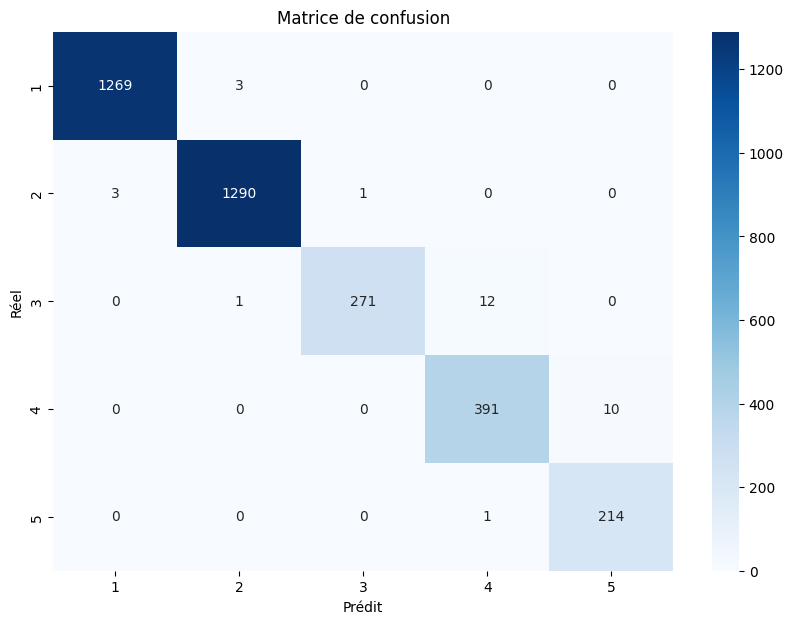

In [140]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculation of the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix with seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title('Matrice de confusion')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()


In [141]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score

# Séparation en jeu de données d'entraînement et de test
X = df_history_preprocessed.drop('aqi', axis=1)[["co", "no", "no2", "o3", "so2", "pm2_5", "pm10", "nh3"]]
y = df_history_preprocessed['aqi']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Entraînement du modèle SVM
model = SVC(random_state=42)
model.fit(X_train, y_train)

# Prédiction sur le jeu de données de test
y_pred = model.predict(X_test)

# Évaluation avec le score F1
score_f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' prend en compte le déséquilibre des classes
print(f"Score F1: {score_f1}")


Score F1: 0.9150298774029348


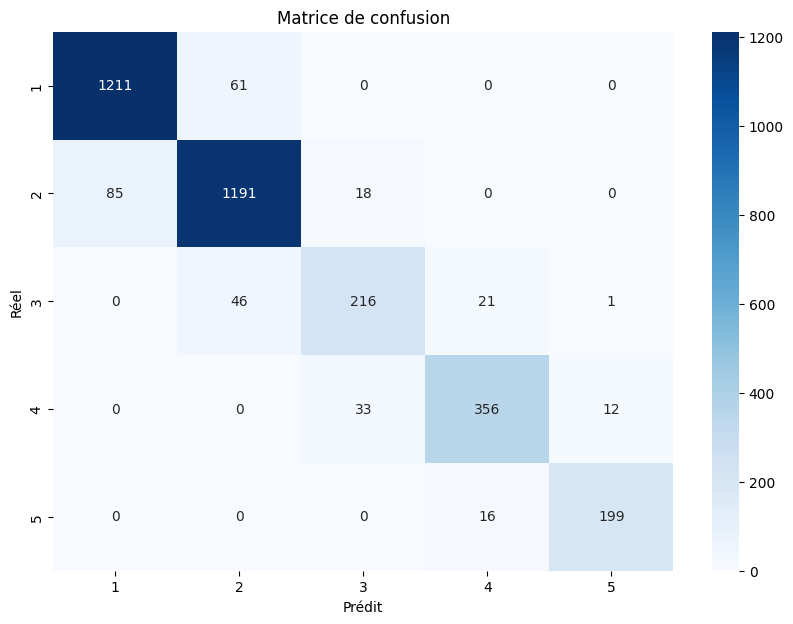

In [142]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculation of the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix with seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title('Matrice de confusion')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()
